In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
df = pd.read_csv('./dataset/processed_dataset.csv')

In [3]:
# Split the data into training and testing sets
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 3. Create pipeline with SMOTE and feature selection
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Using RobustScaler for handling outliers
    ('feature_selection', SelectKBest(f_classif)),
    ('smote', SMOTE(random_state=42)),
    ('logistic', LogisticRegression(random_state=42, max_iter=1000))
])

In [5]:
# 4. Define parameters for GridSearch
param_grid = {
    'feature_selection__k': [5, 7, 9],  # Number of features to select
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'logistic__penalty': ['l1', 'l2'],  # Regularization type
    'logistic__solver': ['liblinear', 'saga']  # Solver algorithms
}

In [6]:
# 5. Perform GridSearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('feature_selection', SelectKBest()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logistic',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [5, 7, 9],
                         'logistic__C': [0.001, 0.01, 0.1, 1, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'logistic__solver': ['liblinear', 'saga']},
             scoring='f1')

In [7]:
# 6. Get best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

In [8]:
# 7. Print model evaluation
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'feature_selection__k': 7, 'logistic__C': 0.001, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     17509
           1       0.44      0.89      0.58      1721

    accuracy                           0.89     19230
   macro avg       0.71      0.89      0.76     19230
weighted avg       0.94      0.89      0.90     19230



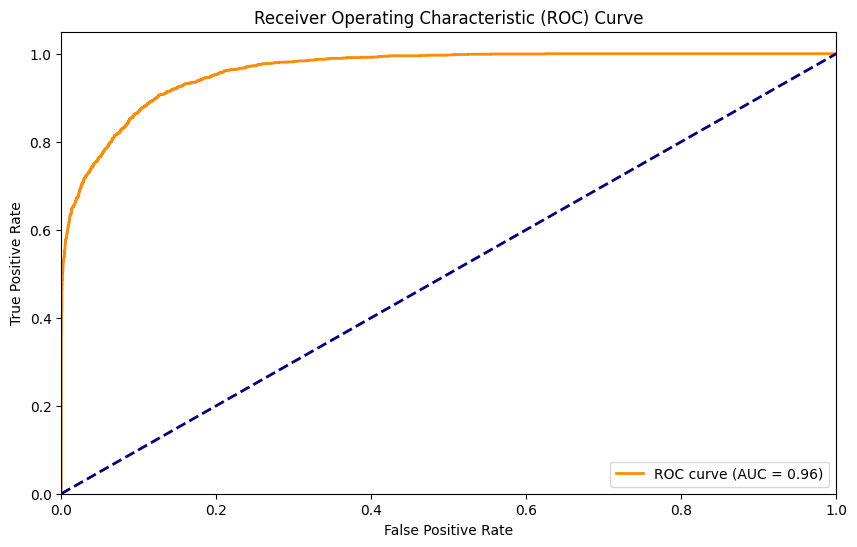

In [9]:
# 8. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

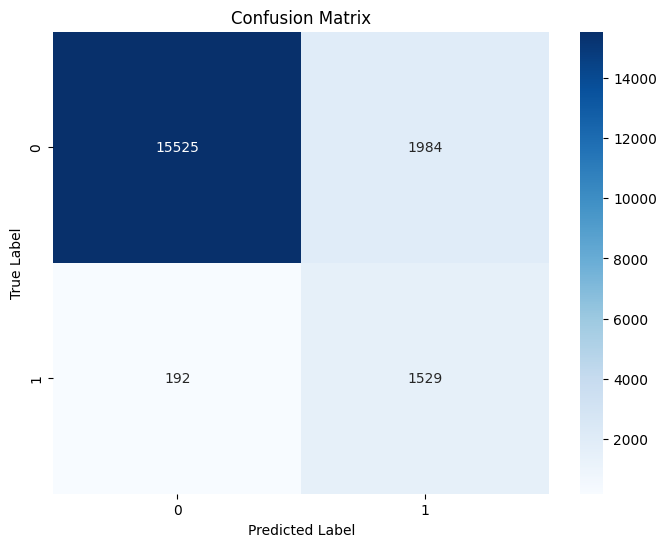

In [10]:
# 9. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

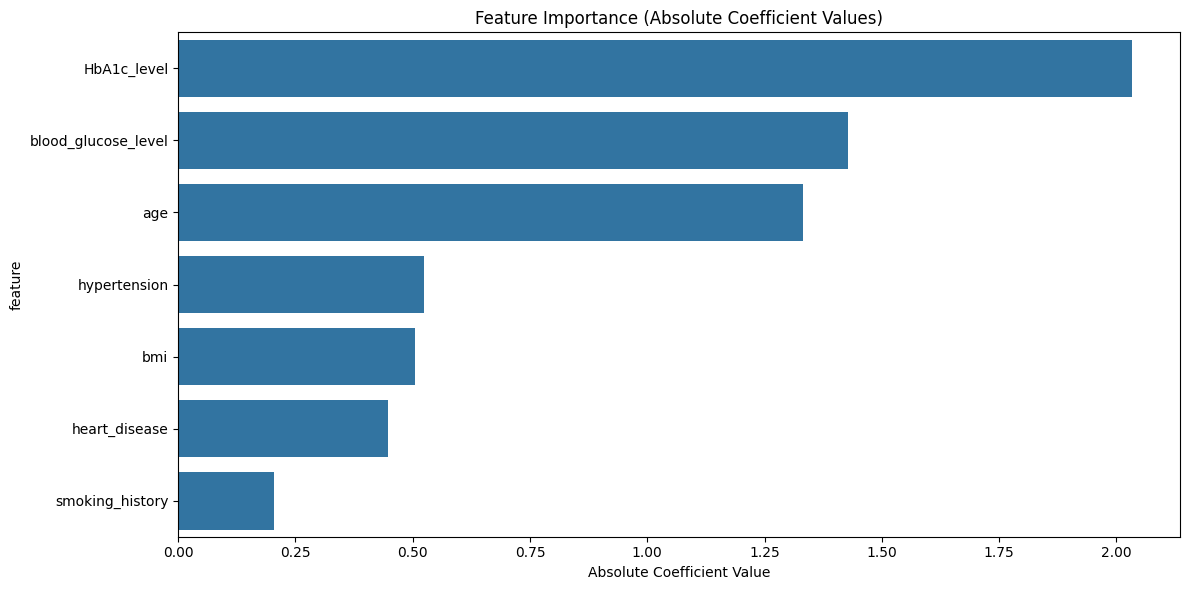

In [11]:
# 10. Feature Importance (using absolute values of coefficients)
feature_selector = best_model.named_steps['feature_selection']
selected_features_mask = feature_selector.get_support()
selected_features = X.columns[selected_features_mask].tolist()
coefficients = best_model.named_steps['logistic'].coef_[0]

feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

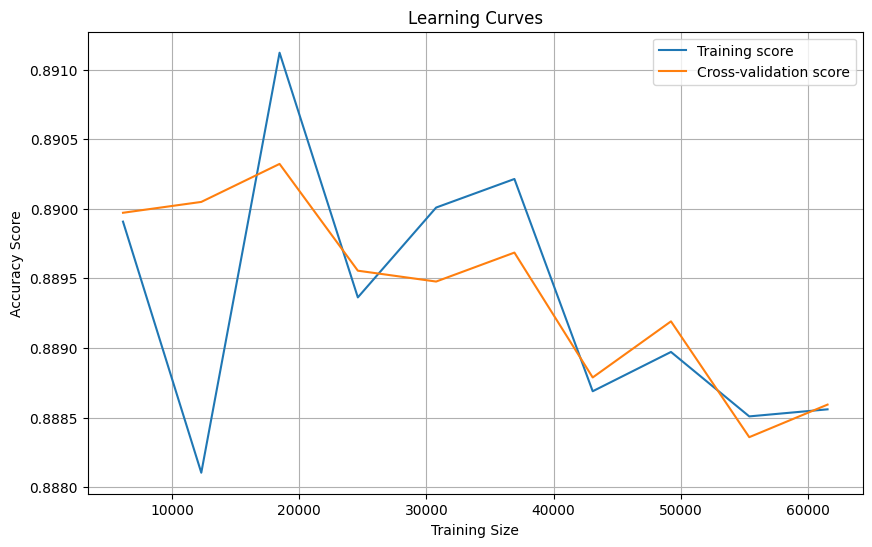

In [12]:
# 11. Learning Curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

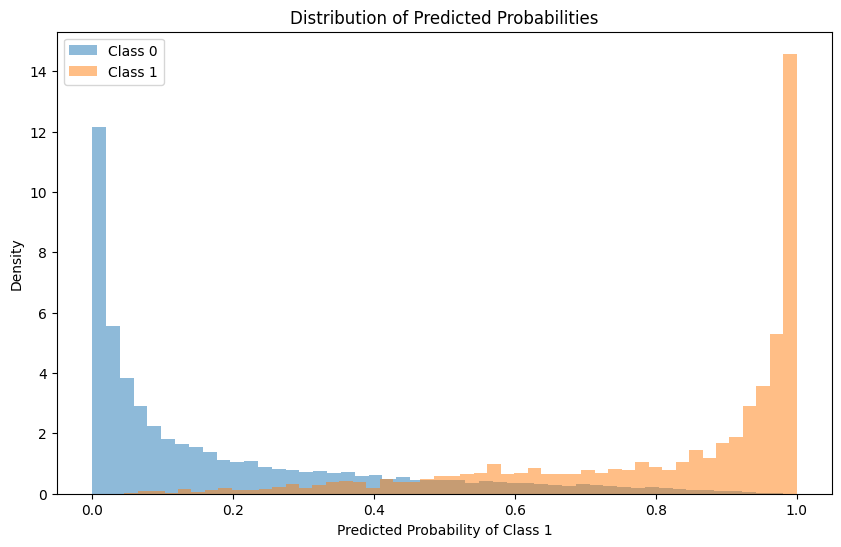

In [13]:
# 12. Probability Distribution
plt.figure(figsize=(10, 6))
for i in range(2):
    mask = y_test == i
    plt.hist(y_pred_proba[mask], bins=50, alpha=0.5, 
             label=f'Class {i}', density=True)
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

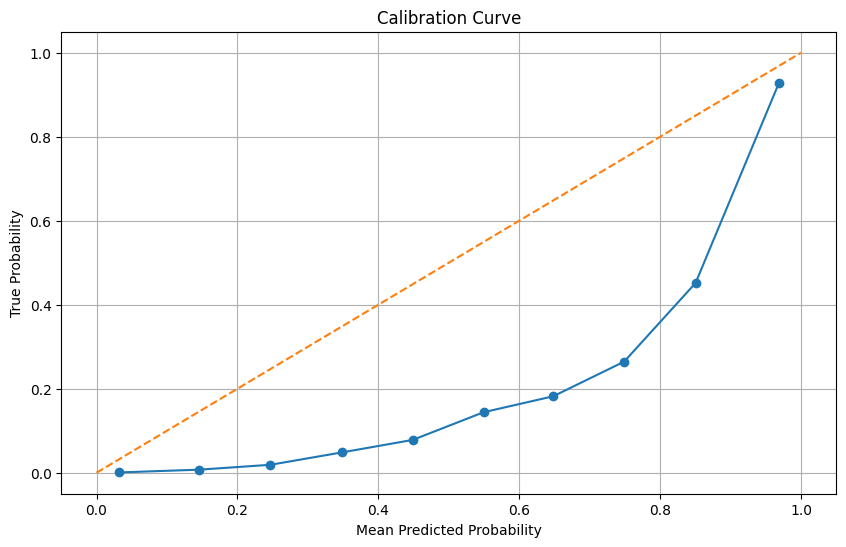

In [14]:
# 13. Calibration Curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

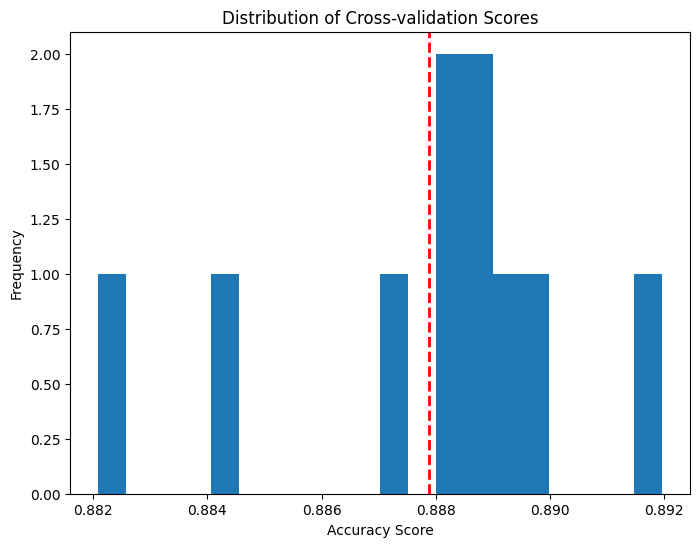


Cross-validation Scores Summary:
Mean Accuracy: 0.888 (+/- 0.005)


In [15]:
# 14. Cross-validation Scores Distribution
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')

plt.figure(figsize=(8, 6))
plt.hist(cv_scores, bins=20)
plt.axvline(cv_scores.mean(), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Distribution of Cross-validation Scores')
plt.show()

print("\nCross-validation Scores Summary:")
print(f"Mean Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")